In [ ]:
# !pip install numpy
# !pip install pillow
# !pip install tensorflow
# !pip install keras
# !pip install opencv-python
# !pip install matplotlib
# !pip install seaborn

# # using dataset https://www.kaggle.com/datasets/stoicstatic/face-recognition-dataset

In [1]:
import os
import tensorflow as tf


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import random
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.applications  import MobileNetV3Large
# from keras.applications  import preprocess_input
from keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

import pandas as pd
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)


2025-09-13 19:45:01.148982: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757767501.163402    7707 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757767501.168283    7707 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-13 19:45:01.184175: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/binngo/miniconda3/envs/pyenv3.11/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDepend

Num GPUs Available:  1


In [2]:
FOLDER_FACE_PATH = './CelebATriplets/images'

def readImage(index):
    path = tf.strings.join([FOLDER_FACE_PATH, "/", index])

    # read file
    img = tf.io.read_file(path)

    # decode JPEG/PNG automatically
    img = tf.image.decode_image(img, channels=3, expand_animations=False)

    # convert dtype to float32 [0,255] → preprocess_input expects this
    img = tf.image.convert_image_dtype(img, tf.float32)

    img = tf.image.resize(img, (160, 160))
    # # resize to MobileNet input size (224x224)
    # img = tf.image.resize(img, (224, 224))
    return img

  

def splitDataset(ratio=0.8):
    tripletsCSV = pd.read_csv('CelebATriplets/triplets.csv')
    tripletsCSV.head(5)
    triplets_list = tripletsCSV[['anchor', 'pos', 'neg']].values.tolist()
    splitIndex = int(len(triplets_list) * ratio)
    train = triplets_list[:splitIndex]
    test = triplets_list[splitIndex:]
            
    return train, test
train, test = splitDataset(0.9)

056279.jpg


I0000 00:00:1757767504.198489    7707 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4699 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1


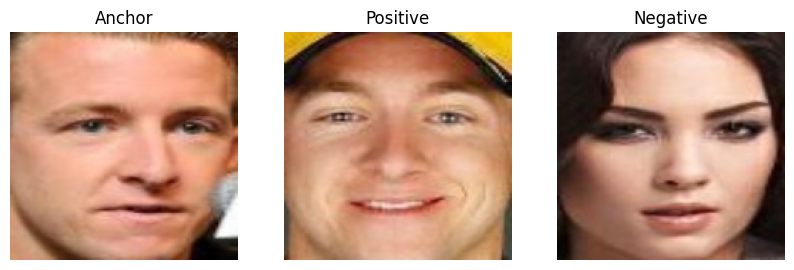

024091.jpg


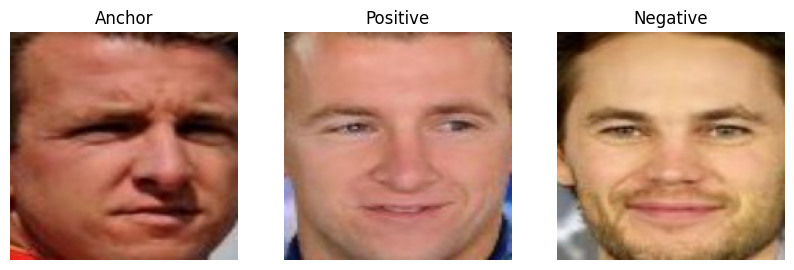

122082.jpg


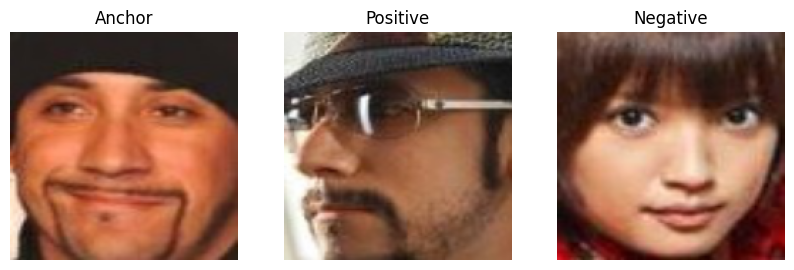

In [3]:
tripletsTrain = train
tripletsTest = test

# Show image triplet
for i in range(3):
    print(tripletsTrain[i][0])
    anchor = readImage(tripletsTrain[i][0])
    positive = readImage(tripletsTrain[i][1])
    negative = readImage(tripletsTrain[i][2])

    plt.figure(figsize=(10,5))
    plt.subplot(1,3,1)
    plt.imshow(anchor)
    plt.title('Anchor')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(positive)
    plt.title('Positive')
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(negative)
    plt.title('Negative')
    plt.axis('off')

    plt.show()




In [4]:

def batchGenerator(triplets, batchSize=32):
     while True:
        anchorBatch, positiveBatch, negativeBatch = [], [], []

        for _ in range(batchSize):
            triplet = random.choice(triplets)
            anchor = readImage(triplet[0])
            positive = readImage(triplet[1])
            negative = readImage(triplet[2])

            anchorBatch.append(anchor)
            positiveBatch.append(positive)
            negativeBatch.append(negative)

        # stack tensors into batch
        anchorBatch = tf.stack(anchorBatch, axis=0)
        positiveBatch = tf.stack(positiveBatch, axis=0)
        negativeBatch = tf.stack(negativeBatch, axis=0)

        # dummy labels (not used in triplet loss, but required by keras)
        labels = tf.zeros((batchSize, 1), dtype=tf.float32)

        yield (anchorBatch, positiveBatch, negativeBatch), labels





In [5]:
def getEmbeddingModel(inputShape):
    baseModel = MobileNetV3Large(input_shape=inputShape, include_top=False, weights='imagenet', pooling='avg')
    for layer in baseModel.layers:
        layer.trainable = False

    model = tf.keras.Sequential([
        baseModel,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name='Embedding')
    return model



In [9]:
#  Create siamese network model with triplet loss

# Distance layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
class DistanceLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
    

def getSiameseModel(inputShape=(128, 128, 3)):
    embeddingModel = getEmbeddingModel(inputShape)

    anchorInput = tf.keras.layers.Input(name='anchor', shape=inputShape)
    positiveInput = tf.keras.layers.Input(name='positive', shape=inputShape)
    negativeInput = tf.keras.layers.Input(name='negative', shape=inputShape)

    anchorEmbedding = embeddingModel(anchorInput)
    positiveEmbedding = embeddingModel(positiveInput)
    negativeEmbedding = embeddingModel(negativeInput)

    # Distance layer
    distances = DistanceLayer()(anchorEmbedding, positiveEmbedding, negativeEmbedding)

    model = tf.keras.Model(inputs=[anchorInput, positiveInput, negativeInput], outputs=distances, name='SiameseNetwork')
    return model

SiameseModel  = getSiameseModel((160, 160, 3))
SiameseModel.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ anchor (InputLayer) │ (None, 160, 160,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positive            │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ negative            │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Embedding           │ (None, 256)       │  3,621,760 │ anchor[0][0],     │
│ (Sequential)        │                   │            │ positive[0][0],   │
│                     │                   │            │ negative[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distance_layer_1    │ [(None), (None)]  │          0 │ Embedding[0][0],  │
│ (DistanceLayer)     │                   │            │ Embedding[1][0],  │
│                     │                   │            │ Embedding[2][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,621,760 (13.82 MB)

 Trainable params: 624,384 (2.38 MB)

 Non-trainable params: 2,997,376 (11.43 MB)

In [10]:
# Custom training step with triplet loss
class SiameseModelClass(tf.keras.Model):
    def __init__(self, siameseModel, margin=0.5):
        super(SiameseModelClass, self).__init__()
        self.siameseModel = siameseModel
        self.margin = margin
        self.lossTracker = tf.keras.metrics.Mean(name='loss')

    def call(self, inputs):
        return self.siameseModel(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            ap_distance, an_distance = self.siameseModel(data[0], training=True)
            loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
            loss = tf.reduce_mean(loss)

        gradients = tape.gradient(loss, self.siameseModel.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siameseModel.trainable_weights))
        self.lossTracker.update_state(loss)
        return {'loss': self.lossTracker.result()}

    def test_step(self, data):
        ap_distance, an_distance = self.siameseModel(data[0], training=False)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        loss = tf.reduce_mean(loss)
        self.lossTracker.update_state(loss)
        return {'loss': self.lossTracker.result()}
    
    
    def _compute_loss(self, data):
        anchor, positive, negative = self.siameseModel(data)
        pos_dist = tf.reduce_sum(tf.square(anchor-positive), -1)
        neg_dist = tf.reduce_sum(tf.square(anchor-negative), -1)
        loss = pos_dist - neg_dist + self.margin
        loss = tf.maximum(loss, 0.0)
        return loss 
    

    @property
    def metrics(self):
        return [self.lossTracker]
    




In [11]:
siameseModel = SiameseModelClass(SiameseModel)
siameseModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

# early stopping callback
cb_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta = 0, 
    patience = 5,
    verbose = 1,
    restore_best_weights = True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
    patience=4, 
    verbose=1, 
    factor=0.3, 
    min_lr=1e-8
)

cb_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'checkpoints/siameseModel_celebA.keras',
    monitor="val_loss",
    mode="min",
    save_best_only = True,
    verbose=1,
)
# data_set = batchGenerator(tripletsTest, batchSize=64)
# train_ds = batchGenerator(tripletsTrain, batchSize=16)
# valid_ds = batchGenerator(tripletsTest, batchSize=16)
# train_ds = tf.data.Dataset.from_generator(
#     lambda: batchGenerator(tripletsTrain, batchSize=32),
#     output_signature=(
#         (tf.TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32),
#          tf.TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32),
#          tf.TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32)),
#         tf.TensorSpec(shape=(None, 1), dtype=tf.float32),
#     )
# ).prefetch(1)

# valid_ds = tf.data.Dataset.from_generator(
#     lambda: batchGenerator(tripletsTest, batchSize=32),
#     output_signature=(
#         (tf.TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32),
#          tf.TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32),
#          tf.TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32)),
#         tf.TensorSpec(shape=(None, 1), dtype=tf.float32),
#     )
# ).prefetch(1)

def map_fn(triplets):
    a = readImage(triplets[0])
    p = readImage(triplets[1])
    n = readImage(triplets[2])
    return (a, p, n), tf.zeros((1,))

train_ds = tf.data.Dataset.from_tensor_slices(tripletsTrain) \
    .shuffle(buffer_size=1000) \
    .map(map_fn, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(64) \
    .prefetch(2)
valid_ds = tf.data.Dataset.from_tensor_slices(tripletsTest) \
    .shuffle(buffer_size=1000) \
    .map(map_fn, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(64) \
    .prefetch(2)


In [ ]:
history = siameseModel.fit(train_ds,
          validation_data=valid_ds,
          callbacks=[cb_early_stopping, cb_model_checkpoint,reduce_lr],
          epochs=128)


Epoch 1/128


I0000 00:00:1757767546.526947    7765 service.cc:148] XLA service 0x71d31c044dd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757767546.526982    7765 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2025-09-13 19:45:47.242777: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1757767549.590707    7765 cuda_dnn.cc:529] Loaded cuDNN version 90101


  1/230 ━━━━━━━━━━━━━━━━━━━━ 1:49:10 29s/step - loss: 0.4349

I0000 00:00:1757767560.553584    7765 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 0.4305
Epoch 1: val_loss improved from None to 0.41489, saving model to checkpoints/siameseModel_celebA.keras


/home/binngo/miniconda3/envs/pyenv3.11/lib/python3.11/site-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


230/230 ━━━━━━━━━━━━━━━━━━━━ 104s 329ms/step - loss: 0.4105 - val_loss: 0.4149 - learning_rate: 1.0000e-04
Epoch 2/128
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 0.3702
Epoch 2: val_loss improved from 0.41489 to 0.39635, saving model to checkpoints/siameseModel_celebA.keras
230/230 ━━━━━━━━━━━━━━━━━━━━ 49s 211ms/step - loss: 0.3660 - val_loss: 0.3963 - learning_rate: 1.0000e-04
Epoch 3/128
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 0.3515
Epoch 3: val_loss did not improve from 0.39635
230/230 ━━━━━━━━━━━━━━━━━━━━ 51s 220ms/step - loss: 0.3487 - val_loss: 0.4019 - learning_rate: 1.0000e-04
Epoch 4/128
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.3344
Epoch 4: val_loss did not improve from 0.39635
230/230 ━━━━━━━━━━━━━━━━━━━━ 47s 206ms/step - loss: 0.3315 - val_loss: 0.4150 - learning_rate: 1.0000e-04
Epoch 5/128
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 0.3216
Epoch 5: val_loss did not improve from 0.39635
230/230 ━━━━━━━━━━━━━━━━━━━━ 51s 221ms/step - lo

In [ ]:
# load best model 
loaded_model = tf.keras.models.load_model("encoder_celeb.weights.h5")
loaded_model.summary() 
def extractEncoder(model):
    encoder = getEmbeddingModel((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extractEncoder(siameseModel)
encoder.save_weights("encoder_celeb.weights.h5")
encoder.summary()

In [ ]:
def classify_images(face_list1, face_list2, threshold=1.1):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)
    
    # Euclidean distance between the encodings
    distance = np.sqrt(np.sum(np.square(tensor1-tensor2), axis=-1))
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction

In [ ]:
pos_list = np.array([])
neg_list = np.array([])

for data in batchGenerator(tripletsTest, batchSize=256):
    print(data)
    a, p, n = data[0]
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

In [ ]:

def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

    # Accuracy, Precision, Recall, F1-Score
    print("\nClassification Report:\n")
    print(classification_report(true, pred, target_names=categories))
ModelMetrics(pos_list, neg_list)

In [ ]:
# test for 2 images
face_1 = readImage(('bin', '4.jpg'))
face_2 = readImage(('bin', '3.jpg'))


face_1 = cv2.resize(face_1, (128, 128))
face_2 = cv2.resize(face_2, (128, 128))

# show images
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(face_1)
plt.title('Face 1')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(face_2)
plt.title('Face 2')
plt.axis('off')
plt.show()

face_1 = preprocess_input(face_1)
face_2 = preprocess_input(face_2)

#
face_1 = tf.convert_to_tensor(np.array([face_1], dtype="float32"))
face_2 = tf.convert_to_tensor(np.array([face_2], dtype="float32"))

prediction = classify_images(face_1, face_2, threshold=1.0)
print('Same person' if prediction[0]==0 else 'Different person')